# LSTM Stock Price Prediction
Predict next-day close prices using LSTM neural networks

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Cell 2: Load and Preview Data
df = pd.read_csv('raw_data/stock_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.drop(columns=['index'], errors='ignore')  # Drop useless index column
df = df.sort_values(['symbol', 'timestamp']).reset_index(drop=True)
print(f"Shape: {df.shape}, Symbols: {df['symbol'].nunique()}")
df.head()

Shape: (250167, 9), Symbols: 1008


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,A,2025-01-08 05:00:00+00:00,137.68,137.68,135.630,137.00,1684573.0,19948.0,137.068421
1,A,2025-01-10 05:00:00+00:00,134.75,140.14,134.709,137.47,1369875.0,25383.0,137.592663
2,A,2025-01-13 05:00:00+00:00,137.22,142.82,137.000,141.95,1561959.0,28739.0,141.776934
3,A,2025-01-14 05:00:00+00:00,142.00,145.38,140.150,143.43,2445434.0,36636.0,143.373405
4,A,2025-01-15 05:00:00+00:00,144.14,146.50,138.680,142.23,2328643.0,35076.0,142.841548


In [3]:
# Cell 3: Feature Engineering - Multi-Scale Technical Indicators
def add_technical_indicators(group):
    """Add multi-scale technical indicators for pattern recognition"""
    g = group.copy()
    
    # Price structure (normalized)
    g['price_range'] = (g['high'] - g['low']) / g['close']
    g['body_size'] = abs(g['close'] - g['open']) / g['close']  # Candle body
    g['upper_shadow'] = (g['high'] - g[['open', 'close']].max(axis=1)) / g['close']
    g['lower_shadow'] = (g[['open', 'close']].min(axis=1) - g['low']) / g['close']
    
    # Multi-scale Moving Averages (% distance from price)
    for period in [5, 10, 20, 50]:
        g[f'sma_{period}'] = g['close'].rolling(period).mean() / g['close'] - 1
    
    # Multi-scale EMAs
    for period in [8, 13, 21, 34]:  # Fibonacci-like
        g[f'ema_{period}'] = g['close'].ewm(span=period, adjust=False).mean() / g['close'] - 1
    
    # Multi-scale RSI
    for period in [7, 14, 21]:
        delta = g['close'].diff()
        gain = delta.clip(lower=0).rolling(period).mean()
        loss = (-delta.clip(upper=0)).rolling(period).mean()
        g[f'rsi_{period}'] = 100 - (100 / (1 + gain / (loss + 1e-10)))
    
    # MACD with signal line
    ema12 = g['close'].ewm(span=12, adjust=False).mean()
    ema26 = g['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema12 - ema26
    g['macd'] = macd_line / g['close']
    g['macd_signal'] = macd_line.ewm(span=9, adjust=False).mean() / g['close']
    g['macd_hist'] = (macd_line - macd_line.ewm(span=9, adjust=False).mean()) / g['close']
    
    # Bollinger Bands (multiple)
    for period in [10, 20]:
        sma = g['close'].rolling(period).mean()
        std = g['close'].rolling(period).std()
        g[f'bb_pos_{period}'] = (g['close'] - sma) / (2 * std + 1e-10)
        g[f'bb_width_{period}'] = (4 * std) / g['close']  # Band width = volatility
    
    # Multi-scale volatility (ATR)
    for period in [7, 14, 21]:
        g[f'atr_{period}'] = g['price_range'].rolling(period).mean()
    
    # Volume patterns
    g['volume_sma_10'] = g['volume'].rolling(10).mean() / (g['volume'] + 1e-10) - 1
    g['volume_sma_20'] = g['volume'].rolling(20).mean() / (g['volume'] + 1e-10) - 1
    g['vwap_diff'] = (g['vwap'] - g['close']) / g['close']
    
    # Price momentum (rate of change) - multi-scale
    for period in [5, 10, 20]:
        g[f'roc_{period}'] = g['close'].pct_change(period)
    
    # Mean reversion signal
    g['close_zscore'] = (g['close'] - g['close'].rolling(20).mean()) / (g['close'].rolling(20).std() + 1e-10)
    
    # Drop warmup rows (need 50 days for longest indicator)
    return g.iloc[50:]

# Apply per-symbol
print("Adding multi-scale technical indicators...")
df_list = []
for symbol in df['symbol'].unique():
    sym_df = df[df['symbol'] == symbol].copy()
    sym_df = add_technical_indicators(sym_df)
    df_list.append(sym_df)

df = pd.concat(df_list, ignore_index=True)
print(f"NaN counts:\n{df.isna().sum()[df.isna().sum() > 0]}")
df = df.dropna().reset_index(drop=True)

print(f"\nAfter feature engineering: {df.shape}, Symbols: {df['symbol'].nunique()}")
print(f"Features created: {len([c for c in df.columns if c not in ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'trade_count', 'returns', 'log_returns', 'gap']])}")
df.head()

Adding multi-scale technical indicators...
NaN counts:
Series([], dtype: int64)

After feature engineering: (199772, 41), Symbols: 1007
Features created: 32


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,price_range,...,atr_7,atr_14,atr_21,volume_sma_10,volume_sma_20,vwap_diff,roc_5,roc_10,roc_20,close_zscore
0,A,2025-03-24 04:00:00+00:00,121.88,124.43,120.89,121.97,1557414.0,20613.0,122.017592,0.029024,...,0.023227,0.028459,0.028147,0.299178,0.451980,0.000390,-0.004245,0.000574,-0.098389,-0.507908
1,A,2025-03-25 04:00:00+00:00,122.60,123.04,119.76,120.51,1605993.0,22981.0,120.927785,0.027218,...,0.021751,0.027575,0.028679,0.228707,0.376896,0.003467,-0.021040,-0.004296,-0.101878,-0.785131
2,A,2025-03-26 04:00:00+00:00,120.72,121.14,119.05,119.90,2652930.0,33845.0,119.894867,0.017431,...,0.021069,0.026711,0.028416,-0.224300,-0.145497,-0.000043,-0.018902,0.000417,-0.108351,-0.978366
3,A,2025-03-27 04:00:00+00:00,120.00,120.33,118.73,118.97,2075742.0,27262.0,119.398051,0.013449,...,0.020924,0.025586,0.028058,-0.004223,0.058546,0.003598,-0.010891,0.013978,-0.063818,-1.175642
4,A,2025-03-28 04:00:00+00:00,119.21,119.66,116.36,116.69,1772883.0,22740.0,116.956686,0.028280,...,0.022708,0.024656,0.027340,0.097866,0.208920,0.002285,-0.033623,-0.037052,-0.087789,-1.779478


In [4]:
# Cell 4: Configuration - Tuned for better accuracy
SEQUENCE_LENGTH = 40
PREDICTION_HORIZON = 5
HIDDEN_SIZE = 256  # Increased capacity

# Multi-scale feature set (no return leakage)
FEATURES = [
    # Price structure
    'price_range', 'body_size', 'upper_shadow', 'lower_shadow',
    # Multi-scale SMAs
    'sma_5', 'sma_10', 'sma_20', 'sma_50',
    # Multi-scale EMAs
    'ema_8', 'ema_13', 'ema_21', 'ema_34',
    # Multi-scale RSI
    'rsi_7', 'rsi_14', 'rsi_21',
    # MACD components
    'macd', 'macd_signal', 'macd_hist',
    # Bollinger bands
    'bb_pos_10', 'bb_width_10', 'bb_pos_20', 'bb_width_20',
    # Multi-scale volatility
    'atr_7', 'atr_14', 'atr_21',
    # Volume
    'volume_sma_10', 'volume_sma_20', 'vwap_diff',
    # Momentum (ROC)
    'roc_5', 'roc_10', 'roc_20',
    # Mean reversion
    'close_zscore'
]

TARGET = 'returns'
TRAIN_SPLIT = 0.8
EPOCHS = 300  # More training
PATIENCE = 35  # More patience
DROPOUT = 0.15  # Less regularization
LEARNING_RATE = 0.0005  # Lower LR for stability
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}, Features: {len(FEATURES)}, Hidden: {HIDDEN_SIZE}, LR: {LEARNING_RATE}")

Device: mps, Features: 32, Hidden: 256, LR: 0.0005


In [5]:
# Cell 5: Data Preparation - predict N-day cumulative return
def prepare_sequences(data, raw_data, seq_len, features, horizon=5):
    """Create sequences for N-day ahead prediction"""
    X, y, prev_close = [], [], []
    feature_data = data[features].values
    close_prices = raw_data['close'].values
    
    # Calculate N-day cumulative return
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(feature_data[i:i+seq_len])
        # Target: return from day (seq_len-1) to day (seq_len + horizon - 1)
        future_close = close_prices[i + seq_len + horizon - 1]
        current_close = close_prices[i + seq_len - 1]
        cumulative_return = (future_close - current_close) / current_close
        y.append(cumulative_return)
        prev_close.append(current_close)
    
    return np.array(X), np.array(y), np.array(prev_close)

In [6]:
# Cell 6: LSTM with Self-Attention
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Bidirectional LSTM for richer patterns
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        # Self-attention over timesteps
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Output layers
        self.bn = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # LSTM: (batch, seq, features) -> (batch, seq, hidden*2)
        lstm_out, _ = self.lstm(x)
        
        # Attention weights: (batch, seq, 1)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        
        # Weighted sum: (batch, hidden*2)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        # Output
        context = self.bn(context)
        return self.fc(context)

# Alias for compatibility
LSTMPredictor = AttentionLSTM

In [7]:
# Cell 7: Custom Loss Function + Training with Directional Penalty
class DirectionalMSELoss(nn.Module):
    """MSE + penalty for wrong direction predictions"""
    def __init__(self, direction_weight=2.0):
        super().__init__()
        self.direction_weight = direction_weight
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        
        # Directional penalty: extra cost when sign is wrong
        pred_sign = torch.sign(pred)
        target_sign = torch.sign(target)
        wrong_direction = (pred_sign != target_sign).float()
        
        # Penalize wrong directions more heavily
        directional_penalty = wrong_direction * torch.abs(target) * self.direction_weight
        
        return (mse_loss + directional_penalty).mean()

def train_model(model, X_train, y_train, X_val, y_val, epochs=150, batch_size=32, lr=0.001, patience=20, verbose=True):
    criterion = DirectionalMSELoss(direction_weight=2.0)  # Custom loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    X_t = torch.FloatTensor(X_train).to(DEVICE)
    y_t = torch.FloatTensor(y_train).reshape(-1, 1).to(DEVICE)
    X_v = torch.FloatTensor(X_val).to(DEVICE)
    y_v = torch.FloatTensor(y_val).reshape(-1, 1).to(DEVICE)
    
    best_val_loss, patience_counter, best_state = float('inf'), 0, None
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        n_batches = 0
        # Shuffle training data
        indices = torch.randperm(len(X_t))
        for i in range(0, len(X_t), batch_size):
            batch_idx = indices[i:i+batch_size]
            # Skip batches with only 1 sample (BatchNorm requires > 1)
            if len(batch_idx) < 2:
                continue
            batch_X, batch_y = X_t[batch_idx], y_t[batch_idx]
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
            n_batches += 1
        
        # Validation (use eval mode - BatchNorm uses running stats, no issue with size)
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_v), y_v).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss, patience_counter = val_loss, 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train: {total_loss:.4f}, Val: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_state)
    return model

In [8]:
# Cell 8: Process All Symbols and Store Results
results = {}
scalers = {}
models = {}

# Use ALL symbols (filter out those with insufficient data)
min_required = SEQUENCE_LENGTH + PREDICTION_HORIZON + 30
symbol_counts = df.groupby('symbol').size()
top_symbols = symbol_counts[symbol_counts >= min_required].index.tolist()
print(f"Training on {len(top_symbols)} symbols (all with >= {min_required} data points)")

Training on 1001 symbols (all with >= 75 data points)


In [9]:
# Cell 9: Train Models with tuned hyperparameters
for symbol in tqdm(top_symbols, desc="Training symbols"):
    sym_data = df[df['symbol'] == symbol].copy()
    raw_data = sym_data.copy()
    
    if len(sym_data) < SEQUENCE_LENGTH + PREDICTION_HORIZON + 30:
        continue
    
    # Store timestamps for later export
    timestamps = raw_data['timestamp'].values
    
    # Scale features
    scaler = MinMaxScaler()
    sym_data[FEATURES] = scaler.fit_transform(sym_data[FEATURES])
    scalers[symbol] = scaler
    
    # Create sequences with N-day horizon
    X, y, prev_close = prepare_sequences(sym_data, raw_data, SEQUENCE_LENGTH, FEATURES, PREDICTION_HORIZON)
    split = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    prev_close_train, prev_close_test = prev_close[:split], prev_close[split:]
    
    # Get actual future close prices
    all_close = raw_data['close'].values[SEQUENCE_LENGTH + PREDICTION_HORIZON - 1:
                                          SEQUENCE_LENGTH + PREDICTION_HORIZON - 1 + len(y)]
    y_close_train, y_close_test = all_close[:split], all_close[split:]
    
    # Get dates for train and test
    all_pred_dates = timestamps[np.arange(len(y)) + SEQUENCE_LENGTH - 1]
    all_target_dates = timestamps[np.arange(len(y)) + SEQUENCE_LENGTH + PREDICTION_HORIZON - 1]
    train_pred_dates, test_pred_dates = all_pred_dates[:split], all_pred_dates[split:]
    train_target_dates, test_target_dates = all_target_dates[:split], all_target_dates[split:]
    
    # Train/val split
    val_split = int(len(X_train) * 0.9)
    X_tr, X_val = X_train[:val_split], X_train[val_split:]
    y_tr, y_val = y_train[:val_split], y_train[val_split:]
    
    # Train model with TUNED params (silent mode)
    model = LSTMPredictor(len(FEATURES), hidden_size=HIDDEN_SIZE, dropout=DROPOUT).to(DEVICE)
    train_model(model, X_tr, y_tr, X_val, y_val, epochs=EPOCHS, patience=PATIENCE, lr=LEARNING_RATE, verbose=False)
    models[symbol] = model
    
    # Predict returns for BOTH train and test
    model.eval()
    with torch.no_grad():
        train_pred_returns = model(torch.FloatTensor(X_train).to(DEVICE)).cpu().numpy().flatten()
        test_pred_returns = model(torch.FloatTensor(X_test).to(DEVICE)).cpu().numpy().flatten()
    
    # Convert predicted returns to prices
    train_pred_prices = prev_close_train * (1 + train_pred_returns)
    test_pred_prices = prev_close_test * (1 + test_pred_returns)
    
    # Metrics (test only)
    mse = mean_squared_error(y_close_test, test_pred_prices)
    mae = mean_absolute_error(y_close_test, test_pred_prices)
    
    # Directional accuracy (test only)
    actual_dir = y_test > 0
    pred_dir = test_pred_returns > 0
    dir_acc = (actual_dir == pred_dir).mean() * 100
    
    results[symbol] = {
        'mse': mse, 'mae': mae, 'dir_acc': dir_acc,
        # Test set
        'y_test': y_close_test, 'preds': test_pred_prices,
        'y_returns': y_test, 'pred_returns': test_pred_returns,
        'pred_dates': test_pred_dates, 'target_dates': test_target_dates,
        # Train set
        'y_train_close': y_close_train, 'train_preds': train_pred_prices,
        'y_train_returns': y_train, 'train_pred_returns': train_pred_returns,
        'train_pred_dates': train_pred_dates, 'train_target_dates': train_target_dates
    }

print(f"\nCompleted training {len(results)} symbols")

Training symbols:   0%|          | 0/1001 [00:00<?, ?it/s]


Completed training 1001 symbols


In [10]:
# Cell 10: Results Summary
results_df = pd.DataFrame({
    k: {'MAE ($)': v['mae'], 'RMSE ($)': np.sqrt(v['mse']), 'Direction Acc (%)': v['dir_acc']} 
    for k, v in results.items()
}).T
print("\nModel Performance Summary (Predicting % Returns → Prices):")
print(f"Average Direction Accuracy: {results_df['Direction Acc (%)'].mean():.1f}%")
results_df


Model Performance Summary (Predicting % Returns → Prices):
Average Direction Accuracy: 49.0%


,MAE ($),RMSE ($),Direction Acc (%)
A,5.047787,6.284703,59.375
AA,6.916219,7.863027,9.375
AAL,1.389955,1.502671,34.375
AAON,9.079043,11.393897,40.625
AAPL,14.411665,19.152139,37.500
...,...,...,...
ZG,4.433784,5.553152,46.875
ZION,3.081421,3.422788,15.625
ZM,2.654263,3.299921,65.625
ZS,34.903738,36.853176,18.750


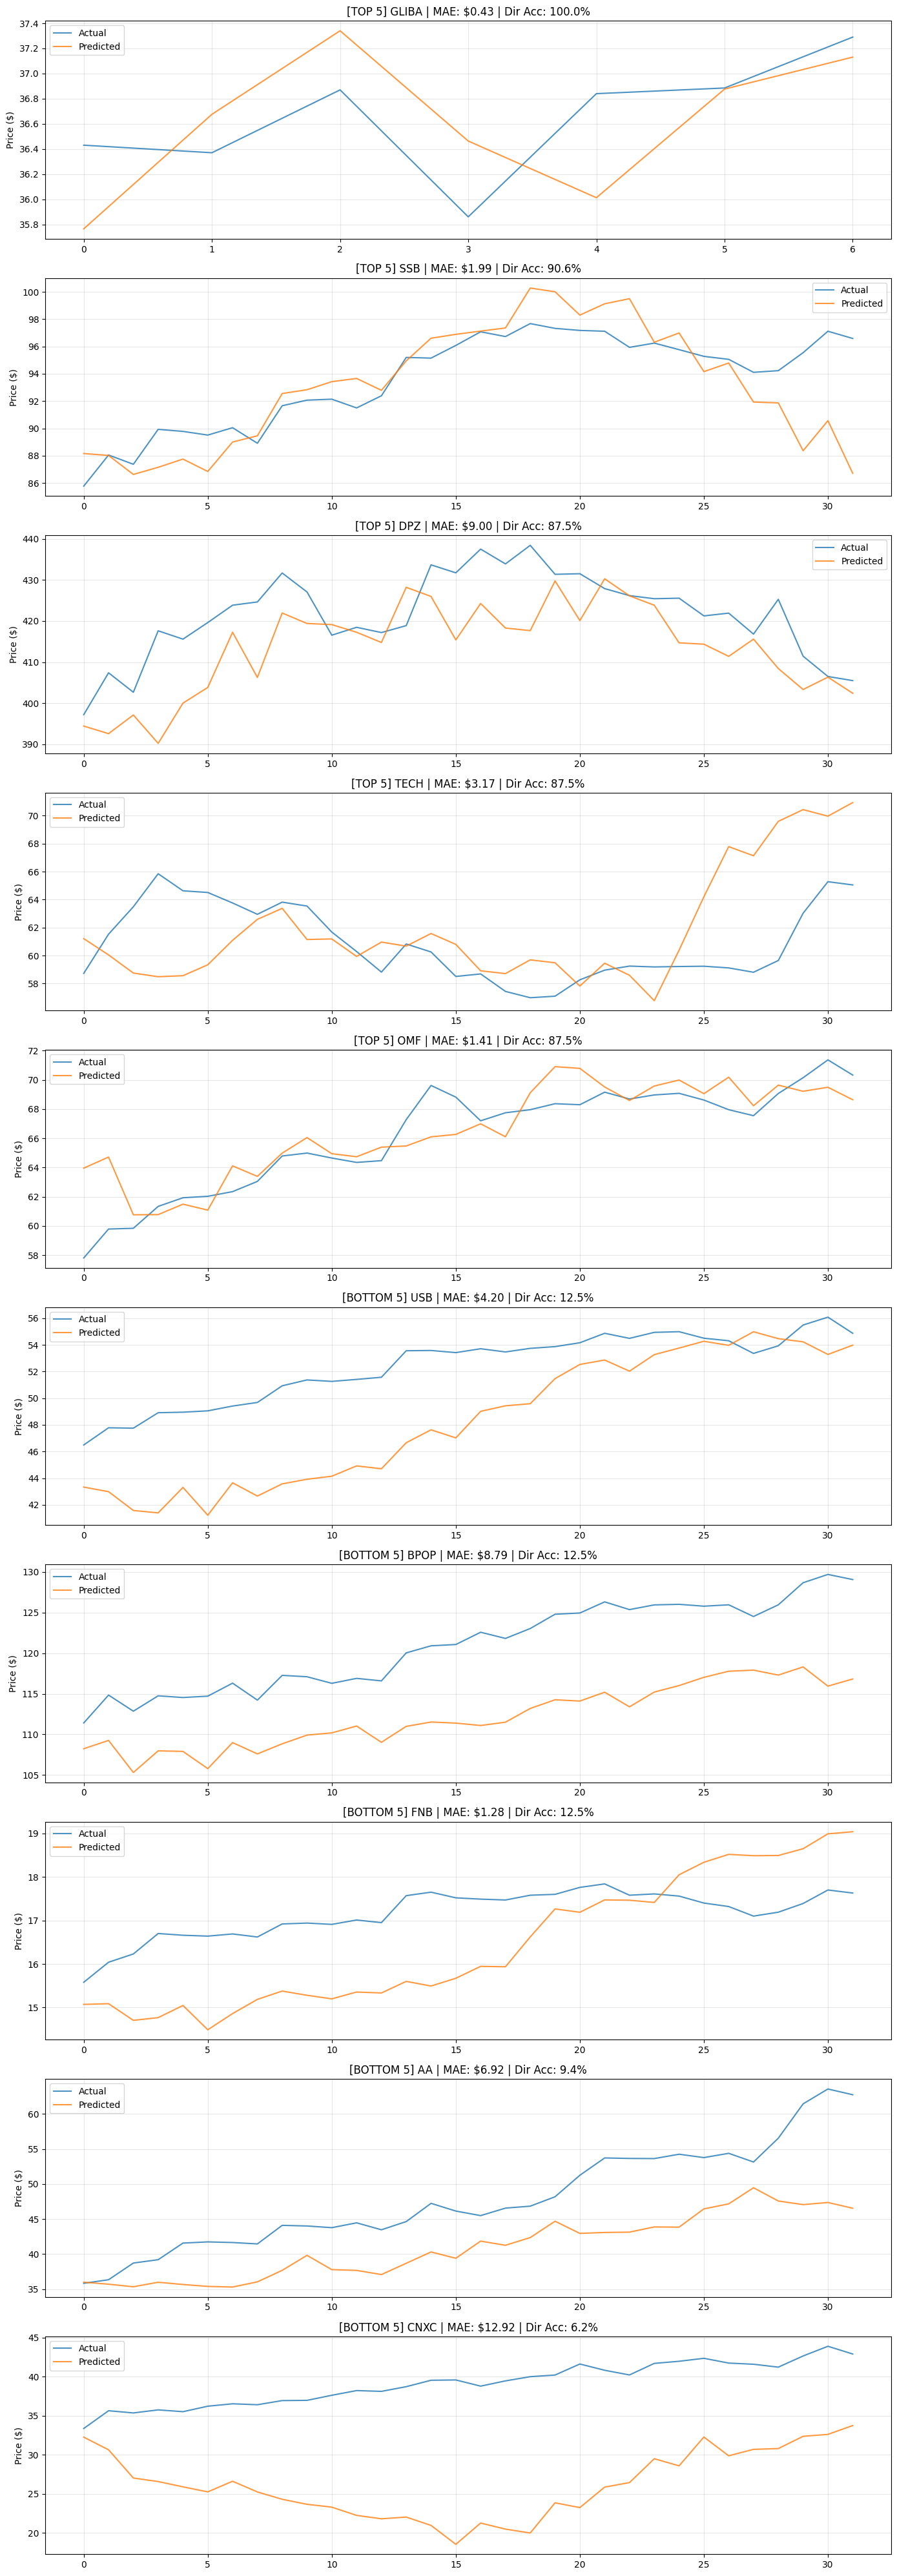

In [16]:
# Cell 11: Visualize Price Predictions (Top 5 Best + Bottom 5 Worst)
# Get top 5 and bottom 5 by direction accuracy
sorted_symbols = results_df.sort_values('Direction Acc (%)', ascending=False)
top5 = sorted_symbols.head(5).index.tolist()
bottom5 = sorted_symbols.tail(5).index.tolist()
plot_symbols = top5 + bottom5

fig, axes = plt.subplots(len(plot_symbols), 1, figsize=(14, 4*len(plot_symbols)))

for ax, symbol in zip(axes, plot_symbols):
    res = results[symbol]
    label = "TOP 5" if symbol in top5 else "BOTTOM 5"
    ax.plot(res['y_test'], label='Actual', alpha=0.8, linewidth=1.5)
    ax.plot(res['preds'], label='Predicted', alpha=0.8, linewidth=1.5)
    ax.set_title(f'[{label}] {symbol} | MAE: ${res["mae"]:.2f} | Dir Acc: {res["dir_acc"]:.1f}%')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

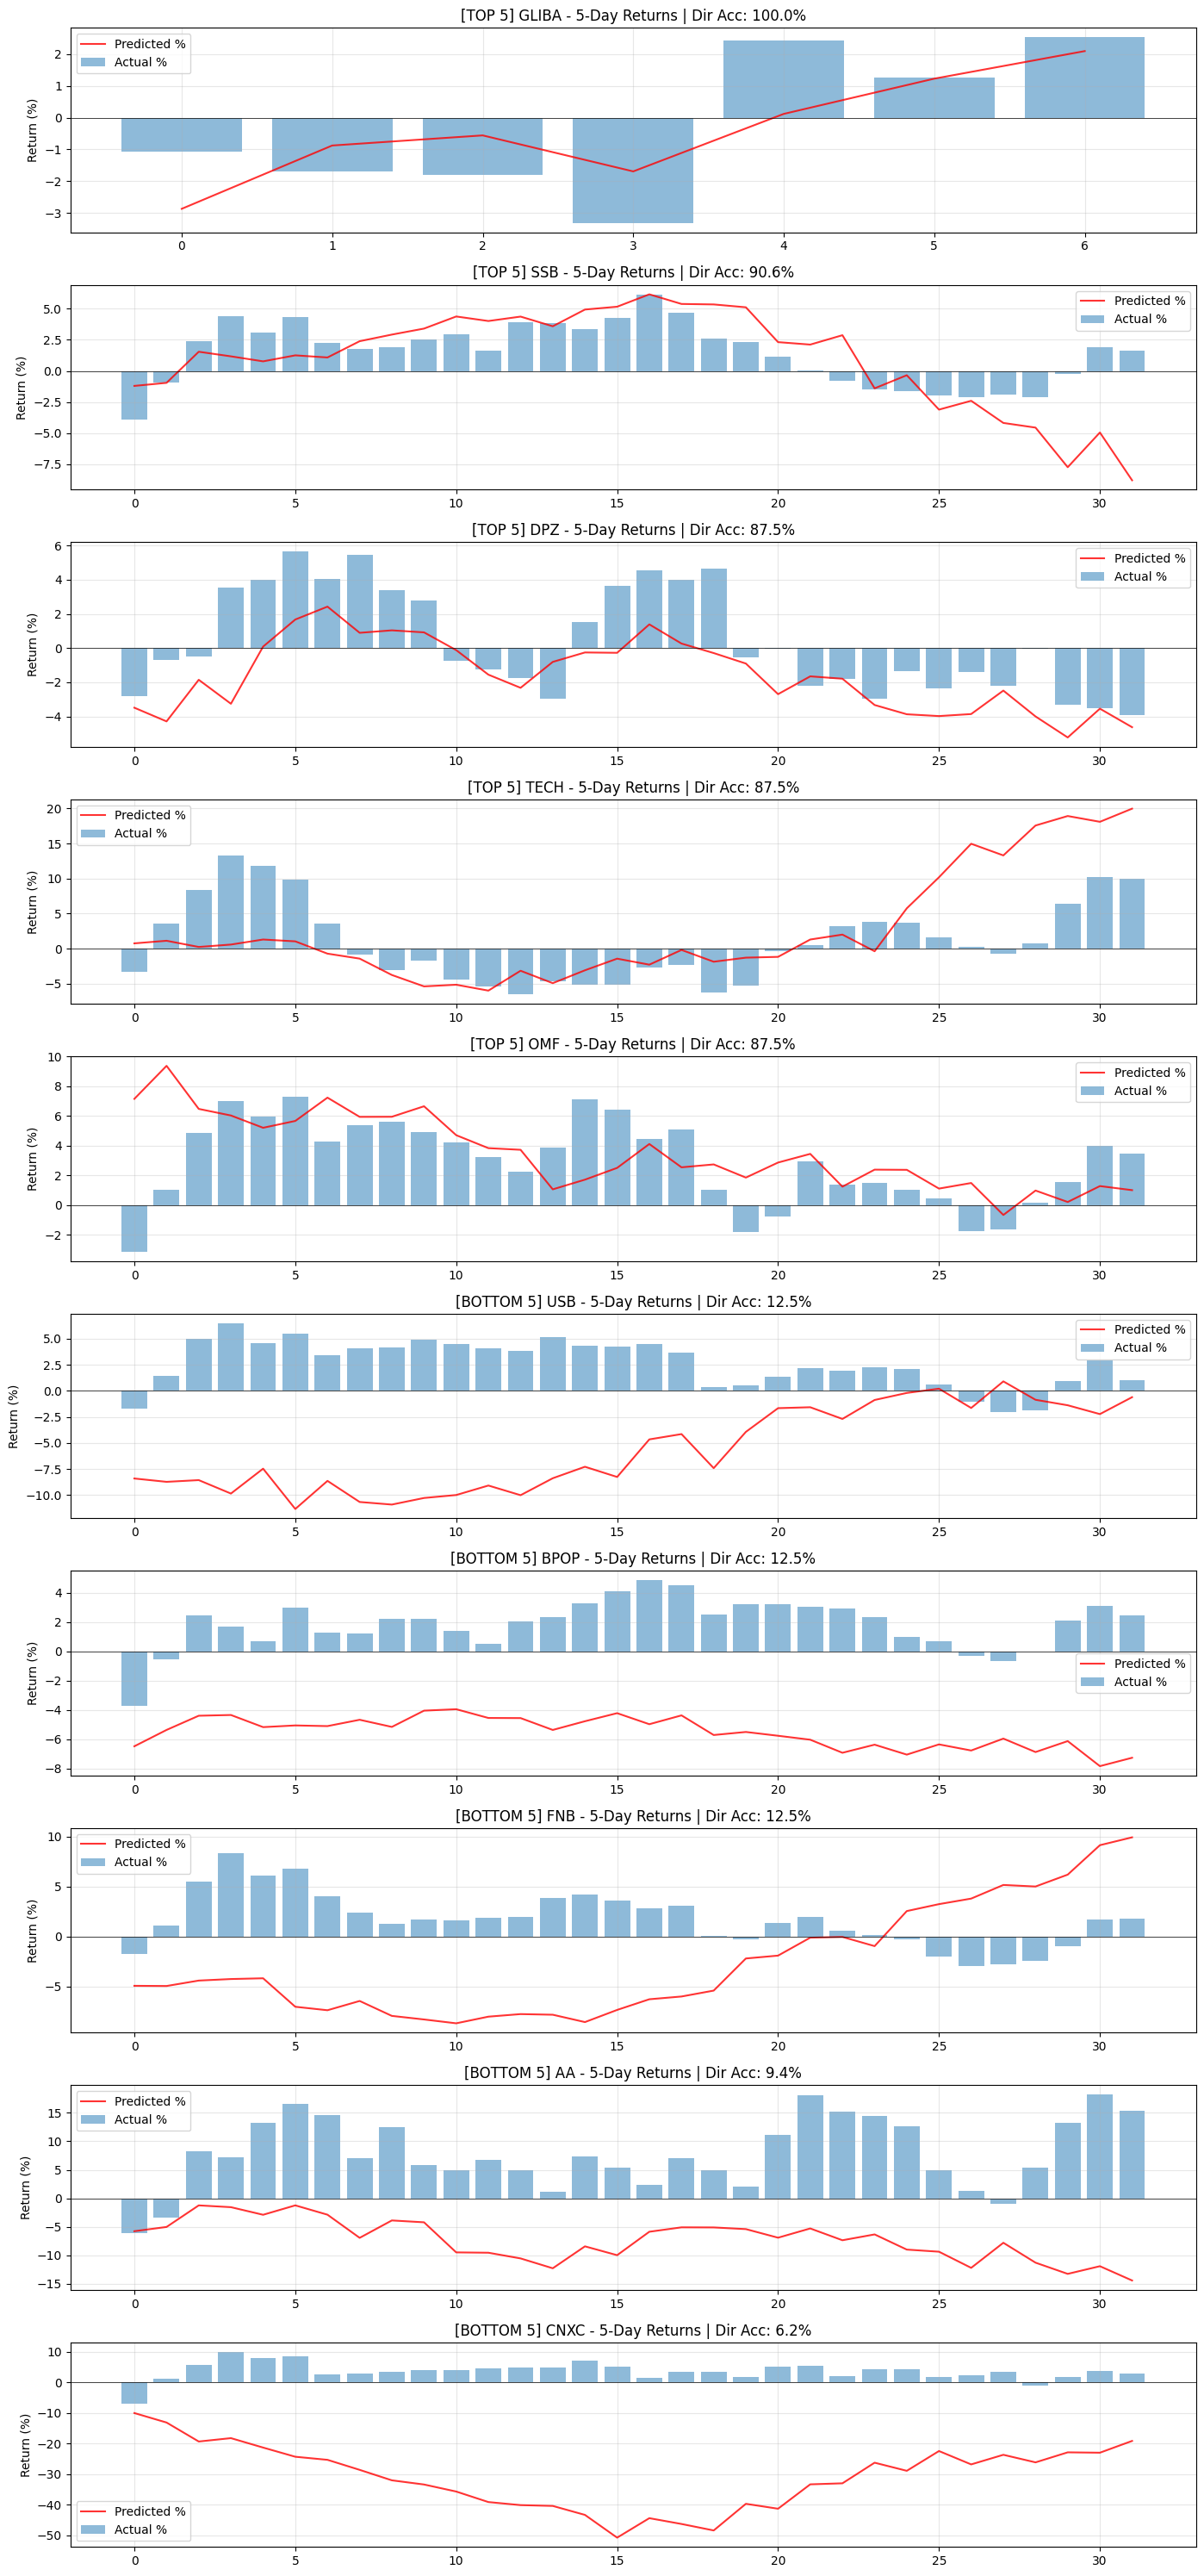

In [17]:
# Cell 12: Visualize Return Predictions (Top 5 Best + Bottom 5 Worst)
fig, axes = plt.subplots(len(plot_symbols), 1, figsize=(14, 3*len(plot_symbols)))

for ax, symbol in zip(axes, plot_symbols):
    res = results[symbol]
    label = "TOP 5" if symbol in top5 else "BOTTOM 5"
    x = range(len(res['y_returns']))
    ax.bar(x, res['y_returns']*100, alpha=0.5, label='Actual %', width=0.8)
    ax.plot(x, res['pred_returns']*100, 'r-', alpha=0.8, linewidth=1.5, label='Predicted %')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'[{label}] {symbol} - 5-Day Returns | Dir Acc: {res["dir_acc"]:.1f}%')
    ax.set_ylabel('Return (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Cell 13: Export All Predictions with Train/Test Split Indicator

dfs = []
for symbol, res in results.items():
    # Test set
    test_df = pd.DataFrame({
        'symbol': symbol,
        'split': 'test',
        'prediction_date': res['pred_dates'],
        'target_date': res['target_dates'],
        'actual_return': res['y_returns'],
        'predicted_return': res['pred_returns'],
        'actual_direction': (res['y_returns'] > 0).astype(int),
        'predicted_direction': (res['pred_returns'] > 0).astype(int),
        'direction_correct': ((res['y_returns'] > 0) == (res['pred_returns'] > 0)).astype(int),
        'actual_price': res['y_test'],
        'predicted_price': res['preds'],
        'symbol_test_accuracy': res['dir_acc'] / 100
    })
    
    # Train set
    train_df = pd.DataFrame({
        'symbol': symbol,
        'split': 'train',
        'prediction_date': res['train_pred_dates'],
        'target_date': res['train_target_dates'],
        'actual_return': res['y_train_returns'],
        'predicted_return': res['train_pred_returns'],
        'actual_direction': (res['y_train_returns'] > 0).astype(int),
        'predicted_direction': (res['train_pred_returns'] > 0).astype(int),
        'direction_correct': ((res['y_train_returns'] > 0) == (res['train_pred_returns'] > 0)).astype(int),
        'actual_price': res['y_train_close'],
        'predicted_price': res['train_preds'],
        'symbol_test_accuracy': res['dir_acc'] / 100  # Still test accuracy for reference
    })
    
    dfs.append(test_df)
    dfs.append(train_df)

predictions_df = pd.concat(dfs, ignore_index=True)
predictions_df = predictions_df.sort_values(['symbol', 'prediction_date']).reset_index(drop=True)
predictions_df.to_csv('processed_data/lstm_predictions.csv', index=False)

print(f"Saved {len(predictions_df)} predictions to processed_data/lstm_predictions.csv")
print(predictions_df.groupby(['symbol', 'split'])['direction_correct'].agg(['mean', 'count']))

Saved 155498 predictions to processed_data/lstm_predictions.csv
                  mean  count
symbol split                 
A      test   0.593750     32
       train  0.362903    124
AA     test   0.093750     32
       train  0.419355    124
AAL    test   0.343750     32
...                ...    ...
ZM     train  0.532258    124
ZS     test   0.187500     32
       train  0.588710    124
ZTS    test   0.718750     32
       train  0.387097    124

[2002 rows x 2 columns]


In [14]:
# Cell 14: Save Full Model Bundle (all symbols)
import pickle

# Save all models, scalers, and config in one bundle
model_bundle = {
    'models': {sym: model.state_dict() for sym, model in models.items()},
    'scalers': scalers,
    'config': {
        'FEATURES': FEATURES,
        'SEQUENCE_LENGTH': SEQUENCE_LENGTH,
        'PREDICTION_HORIZON': PREDICTION_HORIZON,
        'HIDDEN_SIZE': HIDDEN_SIZE,
        'DROPOUT': DROPOUT,
        'symbols': list(models.keys())
    }
}

# Save as pickle
with open('model_archive/lstm_model_bundle.pkl', 'wb') as f:
    pickle.dump(model_bundle, f)

# Save individual model weights
for symbol, model in models.items():
    torch.save(model.state_dict(), f'model_archive/lstm_{symbol}.pt')

print(f"Saved model bundle with {len(models)} symbols to model_archive/lstm_model_bundle.pkl")
print(f"Individual models saved: {list(models.keys())}")

# Save accuracy summary (test set only)
accuracy_df = predictions_df[predictions_df['split'] == 'test'].groupby('symbol').agg({
    'direction_correct': 'mean'
}).rename(columns={'direction_correct': 'test_accuracy'})
accuracy_df.to_csv('processed_data/lstm_accuracy.csv')
print(f"\nAccuracy saved to processed_data/lstm_accuracy.csv")
print(accuracy_df)

Saved model bundle with 1001 symbols to model_archive/lstm_model_bundle.pkl
Individual models saved: ['A', 'AA', 'AAL', 'AAON', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACHC', 'ACI', 'ACM', 'ACN', 'ADBE', 'ADC', 'ADI', 'ADM', 'ADP', 'ADSK', 'ADT', 'AEE', 'AEP', 'AES', 'AFG', 'AFL', 'AFRM', 'AGCO', 'AGNC', 'AGO', 'AIG', 'AIT', 'AIZ', 'AJG', 'AKAM', 'AL', 'ALAB', 'ALB', 'ALGM', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALLY', 'ALNY', 'ALSN', 'AM', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMG', 'AMGN', 'AMH', 'AMKR', 'AMP', 'AMT', 'AMTM', 'AMZN', 'AN', 'ANET', 'AON', 'AOS', 'APA', 'APD', 'APG', 'APH', 'APLS', 'APO', 'APP', 'APPF', 'APTV', 'AR', 'ARE', 'ARES', 'ARMK', 'ARW', 'AS', 'ASH', 'ASTS', 'ATI', 'ATO', 'ATR', 'AU', 'AUR', 'AVB', 'AVGO', 'AVT', 'AVTR', 'AVY', 'AWI', 'AWK', 'AXON', 'AXP', 'AXS', 'AXTA', 'AYI', 'AZO', 'BA', 'BAC', 'BAH', 'BALL', 'BAM', 'BAX', 'BBWI', 'BBY', 'BC', 'BDX', 'BEN', 'BEPC', 'BFAM', 'BG', 'BHF', 'BIIB', 'BILL', 'BIO', 'BIRK', 'BJ', 'BK', 'BKNG', 'BKR', 'BLD', 'BLDR', 'BLK', 'BMRN'